In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

matplotlib.rcParams['hatch.linewidth'] = 0.5

/tmp/ipykernel_16434/3722929927.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from outbreak_data import outbreak_data
from outbreak_tools import outbreak_tools

outbreak_data.print_reqs = True
outbreak_data.default_server = 'dev.outbreak.info'

#### authenticate

In [3]:
import auth_token

from outbreak_data.authenticate_user import set_authentication
set_authentication(auth_token.get_auth_token())

#### pull ww data

In [4]:
state = "Ohio"
state_id = 'USA_US-OH'
startdate, enddate = "2023-09-01", "2024-01-01"
ww_samples = outbreak_data.get_wastewater_samples(region=state, date_range=[startdate, enddate])
ww_samples = outbreak_data.get_wastewater_lineages(ww_samples)

GET https://dev.outbreak.info/wastewater_metadata/query?q=geo_loc_region:Ohio AND collection_date:[2023-09-01 TO 2024-01-01] AND demix_success:true&fetch_all=true
GET https://dev.outbreak.info/wastewater_metadata/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAABj8iRZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=true&page=0&fetch_all=true
GET https://dev.outbreak.info/wastewater_metadata/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAABj8iRZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=true&page=1&fetch_all=true
POST https://dev.outbreak.info/wastewater_demix/query


In [5]:
outbreak_tools.get_ww_weights(ww_samples)

collection_date  lineage    
2023-09-18       EG.2           915024.276644
                 EG.5.1.1       915024.276644
                 FE.1.1.2       915024.276644
                 FL.17.2        915024.276644
                 FP.3           915024.276644
                                    ...      
2023-12-10       BA.2.86         57370.152291
                 EG.11           57370.152291
                 EG.5.1.1        57370.152291
                 XBB.1.16        57370.152291
                 XBB.1.16.17     57370.152291
Name: ww_population, Length: 9857, dtype: float64

In [6]:
ww_abundances = outbreak_tools.datebin_and_agg(ww_samples, weights=outbreak_tools.get_ww_weights(ww_samples), startdate=startdate, enddate=enddate, freq='7D')

#### pull clinical data

In [7]:
clinical_samples = outbreak_data.all_lineage_prevalences(location=state_id, other_threshold=0.0, nday_threshold=1, server='api.outbreak.info')

GET https://api.outbreak.info/genomics/prevalence-by-location-all-lineages?location_id=USA_US-OH&ndays=180&nday_threshold=1&other_threshold=0.0&cumulative=false


In [8]:
clinical_abundances = outbreak_tools.datebin_and_agg(clinical_samples, startdate=startdate, enddate=enddate, freq='7D')

#### get the lineage tree

In [9]:
tree = outbreak_tools.get_compressed_tree()
lineage_key = outbreak_tools.get_lineage_key(tree)

#### cluster lineages on average abundances

In [10]:
viral_load = outbreak_tools.const_idx(ww_samples, 'viral_load', 1)
viral_load = outbreak_tools.datebin_and_agg(viral_load, startdate=startdate, enddate=enddate, freq='7D', column='normed_viral_load', norm=False)['viral_load']

In [11]:
ww_abd_data = ww_abundances.mul(viral_load, axis=0)[-6:].sum()
clinical_abd_data = clinical_abundances.mul(viral_load, axis=0)[-6:].sum()
combined_abundances = (ww_abd_data/ww_abd_data.sum()).add(clinical_abd_data/clinical_abd_data.sum(), fill_value=0)

In [12]:
clusters = outbreak_tools.cluster_lineages(combined_abundances, tree, lineage_key=lineage_key, n=10, alpha=0.25)

#### wastewater plots

In [13]:
def format_dateinterval_axis(ax, index, every_n=4):
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(
        lambda x, pos: index.get_level_values(0)[x].left.date() ))
    ax.set_xticks(np.arange(0, len(index), every_n))
    ax.set_xlabel(None)

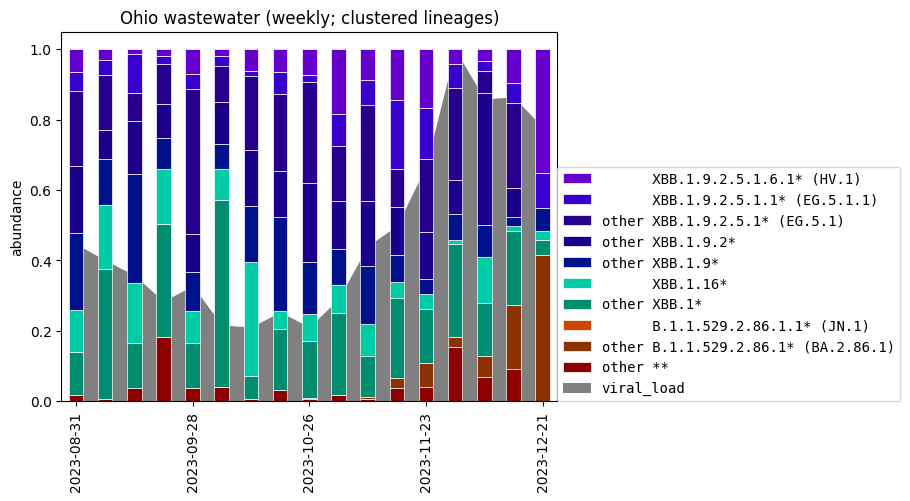

In [14]:
clustered_ww_abundances, root_lineages, isnatural = \
    outbreak_tools.cluster_df(ww_abundances, clusters, tree, lineage_key)
ax = (viral_load / viral_load.max()) \
    .interpolate().bfill().ffill().plot(kind='area', color='gray', linewidth=0)
colors = hsv_to_rgb(outbreak_tools.get_colors(root_lineages, isnatural, lineage_key))
clustered_ww_abundances.plot(
    kind='bar', stacked=True, edgecolor='w', linewidth=.5, color=colors, ax=ax )
format_dateinterval_axis(ax, clustered_ww_abundances.index)
plt.ylabel('abundance')
plt.legend(loc=(1,0), prop={"family":"monospace"}, reverse=True)
plt.title(f'{state} wastewater (weekly; clustered lineages)')
plt.show()

Text(0.5, 1.0, 'Ohio wastewater (weekly; clustered lineages)')

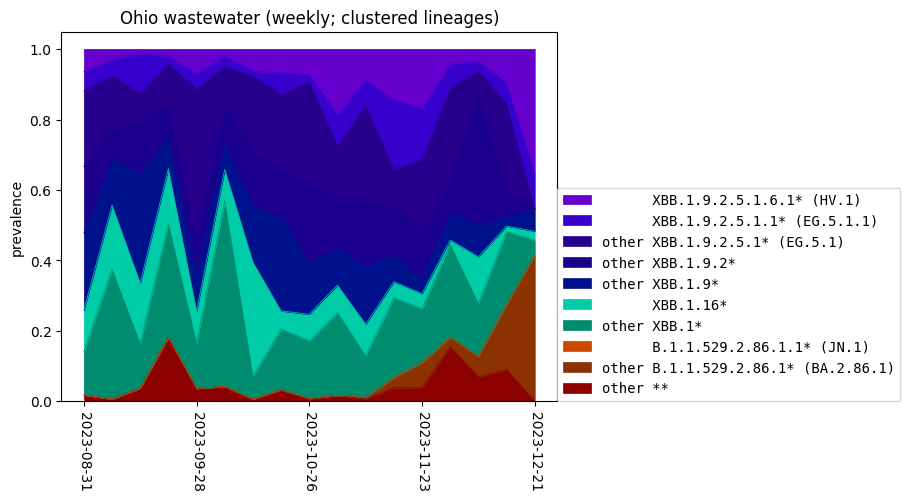

In [15]:
ax = clustered_ww_abundances.plot(kind='area', stacked=True, color=colors, linewidth=0.5)
format_dateinterval_axis(ax, clustered_ww_abundances.index)
plt.legend(loc=(1,0), prop={"family":"monospace"}, reverse=True)
plt.xticks(rotation=-90)
plt.ylabel('prevalence')
plt.title(f'{state} wastewater (weekly; clustered lineages)')

Text(0.5, 1.0, 'Ohio wastewater (weekly; clustered lineages)')

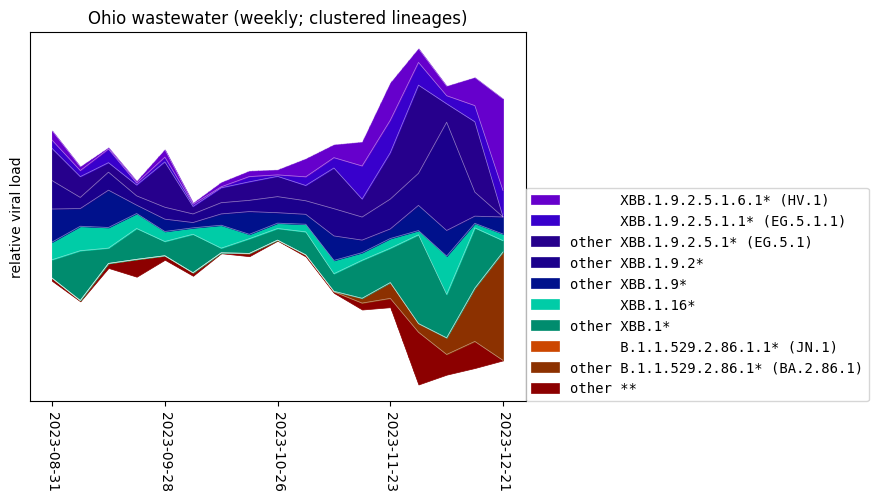

In [16]:
last_line = outbreak_tools.get_riverplot_baseline(clustered_ww_abundances, viral_load)
for lin, color in zip(clustered_ww_abundances.columns, colors):
    next_line = last_line + clustered_ww_abundances[lin] * viral_load.interpolate()
    ix = clustered_ww_abundances[lin].index
    plt.fill_between( ix.astype(str),
                      last_line.interpolate().bfill().ffill(),
                      next_line.interpolate().bfill().ffill(),
                      color=list(color)+[0.25], edgecolor=color, linewidth=0, hatch='|||' )
    plt.plot( ix.astype(str),
              next_line.interpolate(), color='white', linewidth=0.5, alpha=0.5)
    plt.fill_between( ix.astype(str),
                      last_line, next_line, color=list(color), edgecolor=color, linewidth=0.5, label=lin )
    last_line = next_line
plt.legend(loc=(1,0), prop={"family":"monospace"}, reverse=True)
format_dateinterval_axis(plt.gca(), clustered_ww_abundances.index)
plt.xticks(rotation=-90)
plt.ylabel('relative viral load')
plt.yticks([])
plt.title(f'{state} wastewater (weekly; clustered lineages)')

#### clinical plots

Text(0.5, 1.0, 'Ohio clinical (weekly; clustered lineages)')

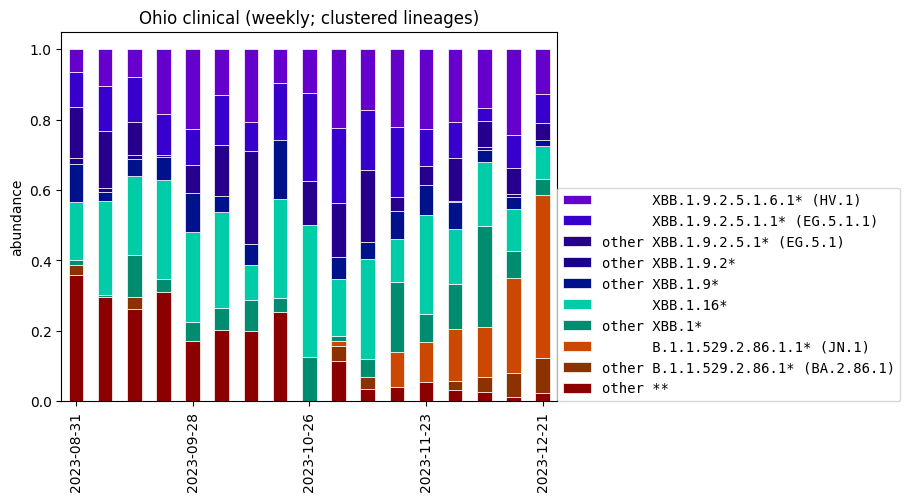

In [17]:
clustered_cl_abundances, root_lineages, isnatural = outbreak_tools.cluster_df(clinical_abundances, clusters, tree, lineage_key)
colors = hsv_to_rgb(outbreak_tools.get_colors(root_lineages, isnatural, lineage_key))
ax = clustered_cl_abundances.plot(
    kind = 'bar', stacked = True, edgecolor = 'w', linewidth = .5, color = colors, ax=plt.gca() )
plt.ylabel('abundance')
plt.legend(loc=(1,0), prop={"family":"monospace"}, reverse=True)
format_dateinterval_axis(ax, clustered_cl_abundances.index)
plt.title(f'{state} clinical (weekly; clustered lineages)')

Text(0.5, 1.0, 'Ohio clinical (weekly; clustered lineages)')

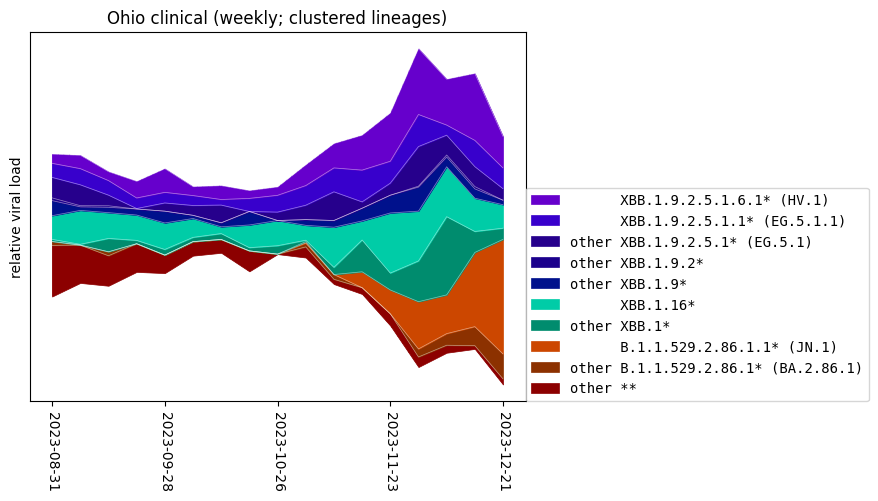

In [18]:
last_line = outbreak_tools.get_riverplot_baseline(clustered_cl_abundances, viral_load)
for lin, color in zip(clustered_cl_abundances.columns, colors):
    next_line = last_line + clustered_cl_abundances[lin] * viral_load.interpolate()
    ix = clustered_cl_abundances[lin].index
    plt.fill_between( ix.astype(str),
                      last_line.interpolate().bfill().ffill(),
                      next_line.interpolate().bfill().ffill(),
                      color=list(color)+[0.25], edgecolor=color, linewidth=0, hatch='|||' )
    plt.plot( ix.astype(str),
              next_line.interpolate(), color='white', linewidth=0.5, alpha=0.5)
    plt.fill_between( ix.astype(str),
                      last_line, next_line, color=list(color), edgecolor=color, linewidth=0.5, label=lin )
    last_line = next_line
plt.legend(loc=(1,0), prop={"family":"monospace"}, reverse=True)
format_dateinterval_axis(plt.gca(), clustered_cl_abundances.index)
plt.xticks(rotation=-90)
plt.ylabel('relative viral load')
plt.yticks([])
plt.title(f'{state} clinical (weekly; clustered lineages)')

#### combined plot

In [19]:
groups = outbreak_tools.gather_groups(clusters, combined_abundances)
clustered_abundances = pd.concat([clustered_ww_abundances, clustered_cl_abundances], keys=['A_wastewater', 'B_clinical'])
gcolors = [[colors[root_lineages.index(n['name'])] for n in g] for g in groups]
groups = [ clustered_abundances[
        [clustered_abundances.columns[root_lineages.index(node['name'])] for node in group]
    ].swaplevel(axis='rows').sort_index() for group in groups]
print(groups[1].tail(6))

                                                         other XBB.1.9*  \
(2023-12-07 00:00:00, 2023-12-14 00:00:00] A_wastewater        0.088792   
                                           B_clinical          0.035498   
(2023-12-14 00:00:00, 2023-12-21 00:00:00] A_wastewater        0.024793   
                                           B_clinical          0.033779   
(2023-12-21 00:00:00, 2023-12-28 00:00:00] A_wastewater        0.065169   
                                           B_clinical          0.017927   

                                                         other XBB.1.9.2*  
(2023-12-07 00:00:00, 2023-12-14 00:00:00] A_wastewater          0.375103  
                                           B_clinical            0.007519  
(2023-12-14 00:00:00, 2023-12-21 00:00:00] A_wastewater          0.082649  
                                           B_clinical            0.008403  
(2023-12-21 00:00:00, 2023-12-28 00:00:00] A_wastewater          0.000000  
                  

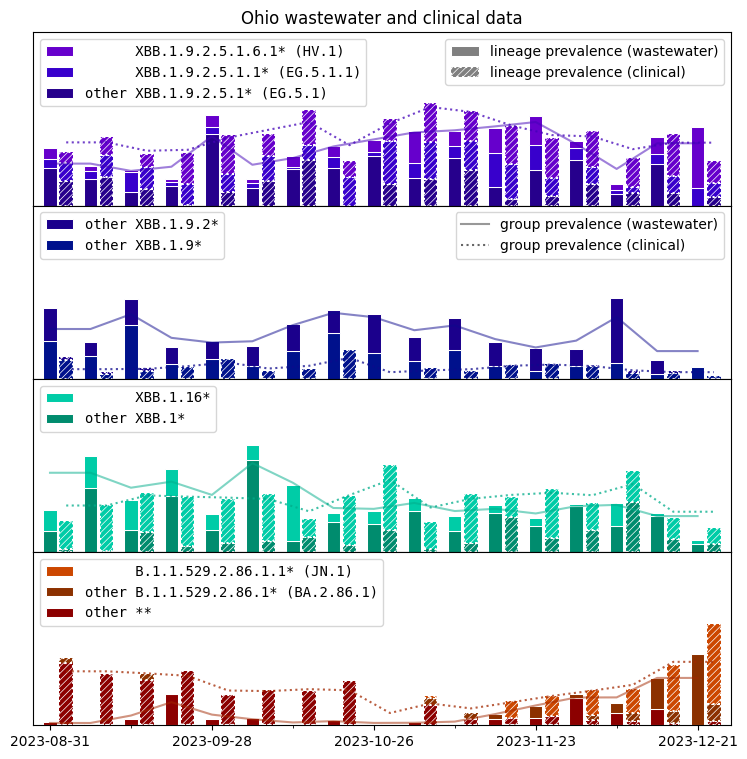

In [20]:
fig, axs = plt.subplots(len(groups),1, sharex=True, figsize=(9,9))
barstyle = { 'linewidth': 0.75, 'edgecolor':'white' }
cbarstyle = { 'linewidth': 1.5, 'linestyle':':', 'hatch': '/////' }
linestyle = { 'alpha': 0.5 }
clinestyle = { 'alpha': 0.75, 'linestyle': ':' }

def trendline(lingroup):
    line = lingroup.sum(axis=1)
    line[lingroup.isna().all(axis=1)] = pd.NA
    line = line.interpolate().rolling(3, closed=None, center=True).mean()/2 + line.interpolate()/2
    return line.bfill().ffill()

for i, (ax, g, c) in enumerate(zip(axs, groups, gcolors)):
    ww = g.xs('A_wastewater', level=1)
    cl = g.xs('B_clinical', level=1)
    ww.plot(kind='bar', stacked=True, width=0.3333, color=c, ax=ax, **barstyle)
    ax.add_artist(ax.legend(loc='upper left', prop={"family":"monospace"}, reverse=True)) # save lin legend
    cl.plot(kind='bar', stacked=True, width=0.3333, color=c, ax=ax, **(barstyle|cbarstyle))
    for cbar in ax.patches[-cl.size:]: cbar.set_x(cbar.get_x() + 0.4) # x-offset clinical bars
    trendline(ww).plot(color=np.mean(c, axis=0), ax=ax, **linestyle)
    trendline(cl).plot(color=np.mean(c, axis=0), ax=ax, **(linestyle|clinestyle))
    ax.lines[-1].set_xdata(ax.lines[-1].get_xdata() + 0.4) # x-offset clinical trend to match bars
    ax.legend().remove() # skip auto legend
    ax.set_yticks([])
    ax.set_ylim(0,1)

axs[0].set_title(f'{state} wastewater and clinical data')
axs[0].legend([ # custom legend for ww v cl bars
        matplotlib.patches.Patch(facecolor='gray', **barstyle),
        matplotlib.patches.Patch(facecolor='gray', **(barstyle|cbarstyle))],
    ['lineage prevalence (wastewater)', 'lineage prevalence (clinical)'], loc='upper right')
axs[1].legend([ # custom legend for ww v clinical lines
        matplotlib.lines.Line2D([], [], color='#333', **linestyle),
        matplotlib.lines.Line2D([], [], color='#333', **(linestyle|clinestyle))],
    ['group prevalence (wastewater)', 'group prevalence (clinical)'], loc='upper right')
axs[-1].set_xlim(axs[-1].get_xlim()[0], axs[-1].get_xlim()[1] + 0.4)
format_dateinterval_axis(axs[-1], ww.index)
plt.subplots_adjust(wspace=0, hspace=0)